## 1) Get the data: SDSS spectra and class labels
<img src="https://www.sdss.org/wp-content/uploads/2014/11/SDSS_telescope_new.jpg" width=500 />
The Sloan Digital Sky Survey (SDSS) is a full-sky survey that has been running at Apache Point Observatory since 2000. Up-to-date information can be found here: https://www.sdss.org/.
In this tutorial we will use spectra taken with spectroscopic plates as shown below. See http://voyages.sdss.org/preflight/sdss-plates/ for more information on these. 
<img src="https://www.sdss.org/wp-content/uploads/2019/11/apogeen-plugging.png" width=300 />

In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import csv
import tensorflow as tf

data_path = 'data_spectra/'

# list of flux values, labels, and wavelength values
data = np.load(data_path + "data.npy")
labels = np.load(data_path + "labels.npy")
wavelengths = np.load(data_path + "wavelengths.npy")
print(np.shape(data))

# list number of objects
numbers = range(np.shape(data)[0])
# datapoints per spectrum
wave_shape = np.shape(data)[1]

(7000, 3522)


## 2) Plot our spectra

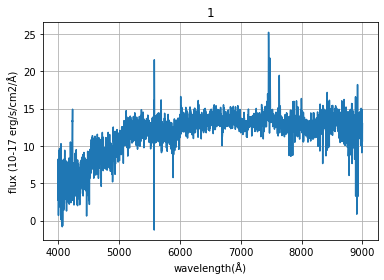

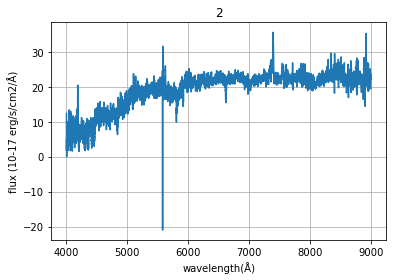

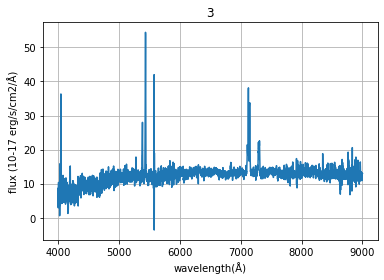

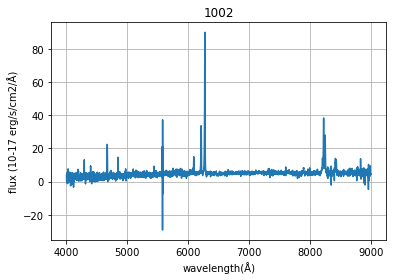

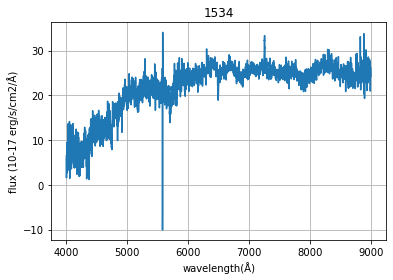

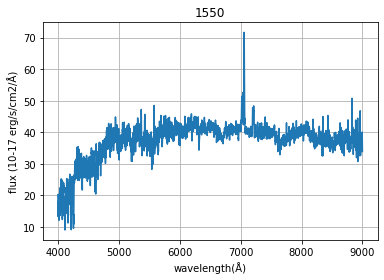

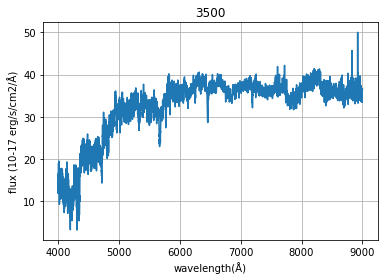

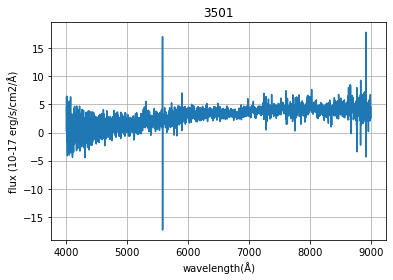

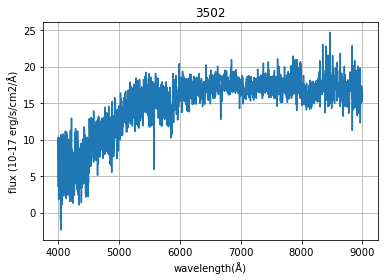

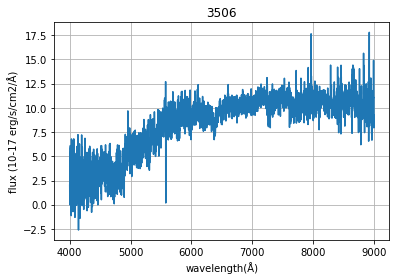

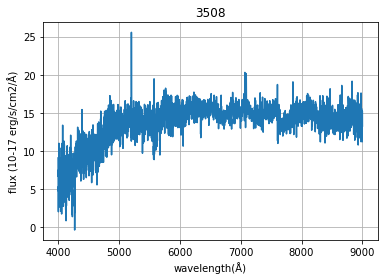

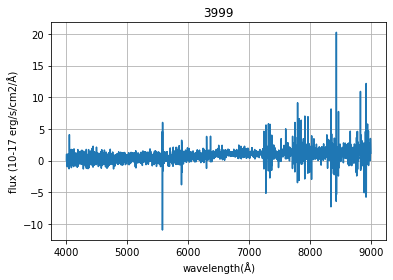

In [32]:
for i in [1, 2, 3, 1002, 1534, 1550, 3500,3501,3502,3506,3508,3999]: # some example spectra
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 erg/s/cm2/Å)') 
    # 10^7 erg = 1 Joule (energy)
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## 3) Create training and test data set

In [5]:
import random

# shuffle the data
z = list(zip(data, labels, numbers)) 
random.shuffle(z)
data_shuffled, labels_shuffled, numbers_shuffled = zip(*z)

print(np.array(data_shuffled).shape)
print(np.array(labels_shuffled).shape)

(7000, 3522)
(7000,)


In [6]:
# test and training split
percent_split = 0.9
split_index = int(len(data_shuffled)*percent_split)

# Flux
data_training = np.asarray(data_shuffled[:split_index])
data_test = np.asarray(data_shuffled[split_index:])

# Labels
labels_training = np.asarray(labels_shuffled[:split_index])
labels_test = np.asarray(labels_shuffled[split_index:])

# Number
numbers_training = numbers_shuffled[:split_index]
numbers_test = numbers_shuffled[split_index:]

In [8]:
# reshape training and test set
input_shape = (wave_shape,1)

data_training_r = np.reshape(data_training, newshape=(len(data_training), input_shape[0], input_shape[1]))
data_test_r  = np.reshape(data_test, newshape=(len(data_test), input_shape[0], input_shape[1]))

print(data_training_r.shape)
print(data_test_r.shape)

(6300, 3522, 1)
(700, 3522, 1)


In [11]:
# further set-up of training and test data, optional normalization
do_normalize = True

if do_normalize:
    # L2-normalization (i.e. the sum of squared of elements is set equal to one)
    x_train = tf.keras.utils.normalize(data_training_r, axis=1)
    x_test = tf.keras.utils.normalize(data_test_r, axis=1)
else:
    x_train = data_training_r
    x_test = data_test_r

y_train = labels_training
y_test = labels_test

## 4) Create the network

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, InputLayer, GlobalAveragePooling1D
from tensorflow.keras.metrics import Accuracy
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
# create network model
# example - try out what happens if you alter different hyperparameters

no_filter = 32
kernel_size = 20
strides = 10
dropout = 0.35
pooling = 3

# our model or architecture
model = tf.keras.Sequential([
    # add convolutional layer
    Conv1D(filters=no_filter, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape), # stride
    # max-pooling against overfitting
    MaxPooling1D(pooling), 
    # dropout against overfitting
    Dropout(dropout), 
    # add convolutional layer
    Conv1D(filters=2*no_filter, kernel_size=2*kernel_size, strides=strides, activation='relu'),
    # max-pooling against overfitting
    MaxPooling1D(pooling),
    # dropout against overfitting
    Dropout(dropout),
    # flatten to feed into dense layers
    Flatten(),
    # Adds a densely-connected layer
    Dense(units=128, activation='relu'), # units = dimensionality of output
    # dropout again
    Dropout(dropout),
    # Add another dense layer, now a softmax (probability of different classes as the output)
    Dense(units=4, activation='softmax')
])

In [33]:
# compile the network model, choose optimiser, loss-function etc.
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', # labels provided as integers (not one-hot)
              metrics=['accuracy'])

In [12]:
# train the network model
history = model.fit(x_train, y_train,
                    epochs=200, validation_split=0.1,
                    shuffle=True, batch_size=200,
                    verbose=1)

# we can also save and/or load a model
#model = tf.keras.models.load_model('spectral_classifier_v2.h5')
#model.save('spectral_classifier_v2.h5')

Train on 5670 samples, validate on 630 samples
Epoch 1/200
5670/5670 [==============================] - 1s 199us/sample - loss: 1.2119 - acc: 0.3471 - val_loss: 1.0739 - val_acc: 0.4397
Epoch 2/200
5670/5670 [==============================] - 1s 154us/sample - loss: 1.0619 - acc: 0.4203 - val_loss: 0.9314 - val_acc: 0.6175
Epoch 3/200
5670/5670 [==============================] - 1s 153us/sample - loss: 0.8298 - acc: 0.5743 - val_loss: 0.6918 - val_acc: 0.6587
Epoch 4/200
5670/5670 [==============================] - 1s 160us/sample - loss: 0.6992 - acc: 0.6196 - val_loss: 0.6566 - val_acc: 0.6762
Epoch 5/200
5670/5670 [==============================] - 1s 160us/sample - loss: 0.6707 - acc: 0.6481 - val_loss: 0.6378 - val_acc: 0.6857
Epoch 6/200
5670/5670 [==============================] - 1s 152us/sample - loss: 0.6500 - acc: 0.6697 - val_loss: 0.6272 - val_acc: 0.6984
Epoch 7/200
5670/5670 [==============================] - 1s 156us/sample - loss: 0.6386 - acc: 0.6735 - val_loss: 0.620

5670/5670 [==============================] - 1s 172us/sample - loss: 0.3996 - acc: 0.8228 - val_loss: 0.4144 - val_acc: 0.8270
Epoch 60/200
5670/5670 [==============================] - 1s 172us/sample - loss: 0.3920 - acc: 0.8296 - val_loss: 0.3884 - val_acc: 0.8333
Epoch 61/200
5670/5670 [==============================] - 1s 171us/sample - loss: 0.3866 - acc: 0.8242 - val_loss: 0.4145 - val_acc: 0.8143
Epoch 62/200
5670/5670 [==============================] - 1s 171us/sample - loss: 0.3837 - acc: 0.8328 - val_loss: 0.3932 - val_acc: 0.8302
Epoch 63/200
5670/5670 [==============================] - 1s 171us/sample - loss: 0.3787 - acc: 0.8325 - val_loss: 0.3895 - val_acc: 0.8365
Epoch 64/200
5670/5670 [==============================] - 1s 163us/sample - loss: 0.3822 - acc: 0.8349 - val_loss: 0.3818 - val_acc: 0.8397
Epoch 65/200
5670/5670 [==============================] - 1s 168us/sample - loss: 0.3861 - acc: 0.8340 - val_loss: 0.3794 - val_acc: 0.8413
Epoch 66/200
5670/5670 [=========

5670/5670 [==============================] - 1s 183us/sample - loss: 0.2972 - acc: 0.8774 - val_loss: 0.3210 - val_acc: 0.8746
Epoch 118/200
5670/5670 [==============================] - 1s 182us/sample - loss: 0.2918 - acc: 0.8787 - val_loss: 0.3236 - val_acc: 0.8651
Epoch 119/200
5670/5670 [==============================] - 1s 182us/sample - loss: 0.2969 - acc: 0.8721 - val_loss: 0.3106 - val_acc: 0.8794
Epoch 120/200
5670/5670 [==============================] - 1s 184us/sample - loss: 0.2878 - acc: 0.8825 - val_loss: 0.3215 - val_acc: 0.8794
Epoch 121/200
5670/5670 [==============================] - 1s 182us/sample - loss: 0.2806 - acc: 0.8868 - val_loss: 0.3059 - val_acc: 0.8905
Epoch 122/200
5670/5670 [==============================] - 1s 181us/sample - loss: 0.2824 - acc: 0.8824 - val_loss: 0.3184 - val_acc: 0.8778
Epoch 123/200
5670/5670 [==============================] - 1s 183us/sample - loss: 0.2827 - acc: 0.8838 - val_loss: 0.3094 - val_acc: 0.8857
Epoch 124/200
5670/5670 [==

5670/5670 [==============================] - 1s 169us/sample - loss: 0.2373 - acc: 0.9034 - val_loss: 0.2863 - val_acc: 0.8984
Epoch 176/200
5670/5670 [==============================] - 1s 171us/sample - loss: 0.2459 - acc: 0.9009 - val_loss: 0.2962 - val_acc: 0.8905
Epoch 177/200
5670/5670 [==============================] - 1s 171us/sample - loss: 0.2365 - acc: 0.9034 - val_loss: 0.3025 - val_acc: 0.8857
Epoch 178/200
5670/5670 [==============================] - 1s 165us/sample - loss: 0.2318 - acc: 0.9069 - val_loss: 0.3037 - val_acc: 0.8905
Epoch 179/200
5670/5670 [==============================] - 1s 173us/sample - loss: 0.2294 - acc: 0.9049 - val_loss: 0.2995 - val_acc: 0.8921
Epoch 180/200
5670/5670 [==============================] - 1s 167us/sample - loss: 0.2285 - acc: 0.9071 - val_loss: 0.3182 - val_acc: 0.8889
Epoch 181/200
5670/5670 [==============================] - 1s 166us/sample - loss: 0.2369 - acc: 0.8963 - val_loss: 0.3097 - val_acc: 0.8921
Epoch 182/200
5670/5670 [==

## 5) Monitor the training

In [13]:
def plot_accuracy(name, ylim=[0,1.01]):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ylim[0], ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()

In [14]:
def plot_loss(name, ylim=[0,2]):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(ylim[0],ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()


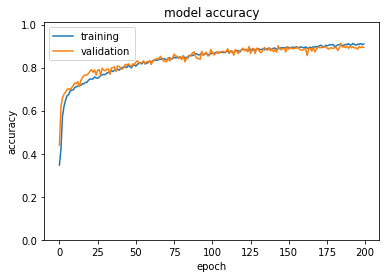

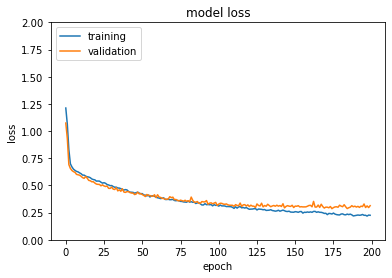

In [15]:
plot_accuracy("accuracy_graph_goldbig.png")
plot_loss("loss_graph_goldbig.png")

## Test the network model - predictive performance

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [17]:
# predict on the test data
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

class_names = ['AGN','galaxy','QSO','star']

### Confusion Matrix

In [18]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[233  17   2]
 [ 32 222   2]
 [ 15   2 175]]


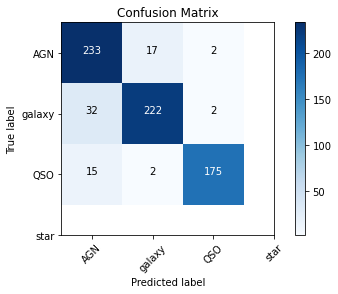

In [19]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=class_names, title='Confusion Matrix')

## Confusion matrix (percentage)

Confusion matrix, without normalization
[[92.46  6.75  0.79]
 [12.5  86.72  0.78]
 [ 7.81  1.04 91.15]]


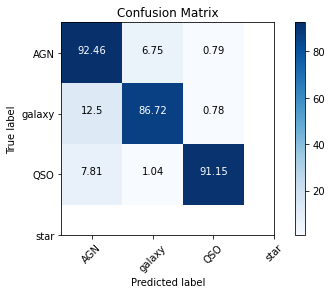

In [20]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
cm_shape = np.shape(cm)

cm_percentages = np.zeros(shape=cm_shape)
for i in range(cm_shape[0]):
    total_objects = sum(cm[i])
    
    for t in range(cm_shape[0]):
        number_guessed = cm[i][t]
        cm_percentages[i][t] = round(number_guessed/total_objects*100,2)

plot_confusion_matrix(cm=cm_percentages, classes=class_names, title='Confusion Matrix')

## Class-wise accuracy

In [21]:
class_accuaracy = []

for i in range(cm_shape[0]):
    total_objects = sum(cm[i])
    correct_guesses = cm[i][i]
    class_accuaracy.append(correct_guesses/total_objects)
    
print("Accuracy for class")
for i in range(cm_shape[0]):
    print(class_names[i], "\t:", round(class_accuaracy[i],4)*100, "%")

Accuracy for class
AGN 	: 92.46 %
galaxy 	: 86.72 %
QSO 	: 91.14999999999999 %


## Having a look at false predictions

**Label 0 = AGN** \
**Label 1 = galaxy** \
**Label 2 = QSO** \
**Label 3 = star**

In [22]:
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

wrong_predictions = []

for i in range(len(rounded_predictions)):
    if rounded_predictions[i] != y_test[i]:
        wrong_predictions.append(numbers_test[i])      

wrong_predictions.sort()
        
print(len(rounded_predictions), "right")
print(len(wrong_predictions), "false")
print(str(((len(rounded_predictions)-len(wrong_predictions))/len(rounded_predictions))*100) + "% correctly classified")

700 right
70 false
90.0% correctly classified


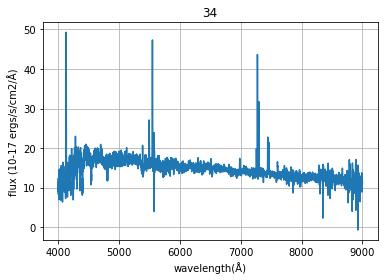

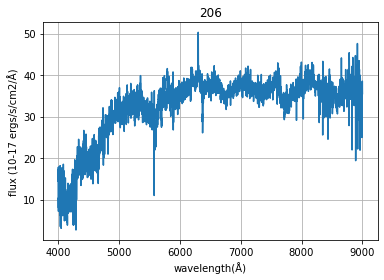

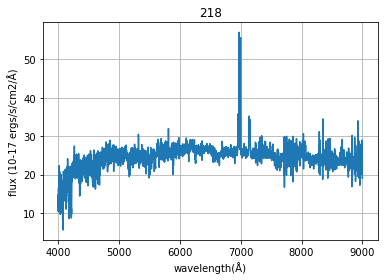

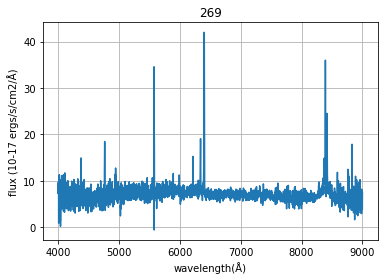

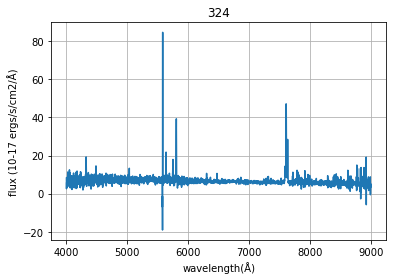

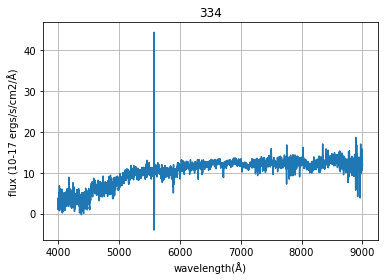

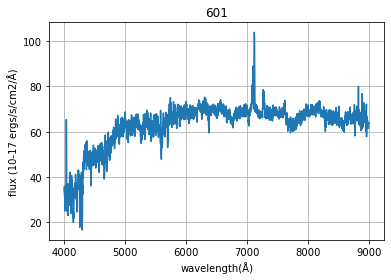

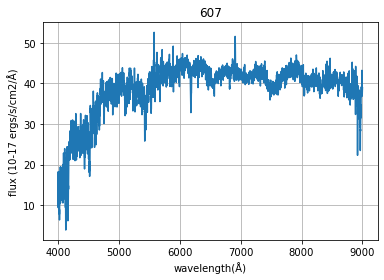

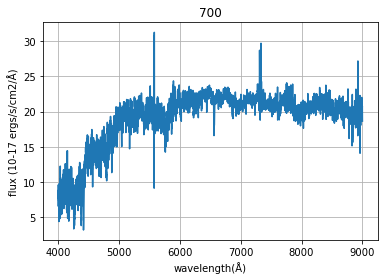

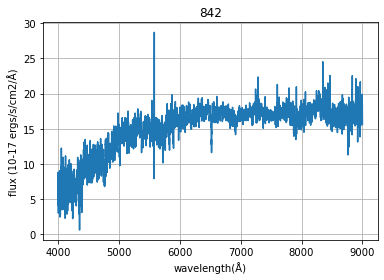

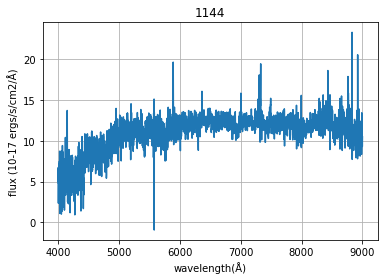

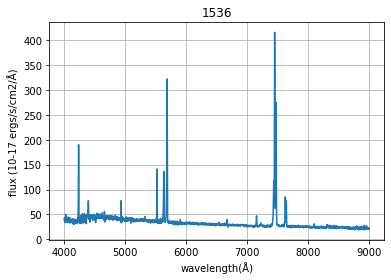

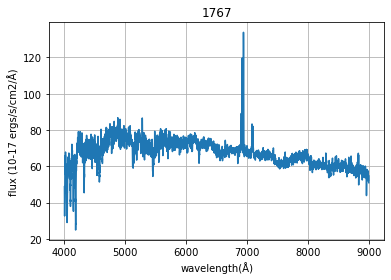

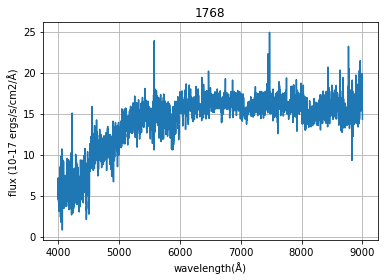

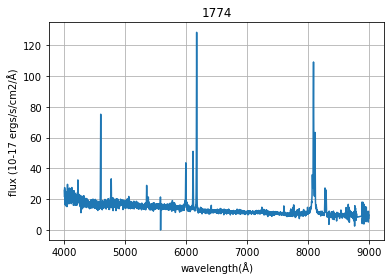

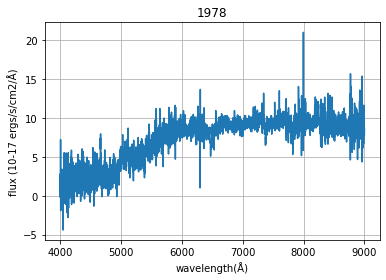

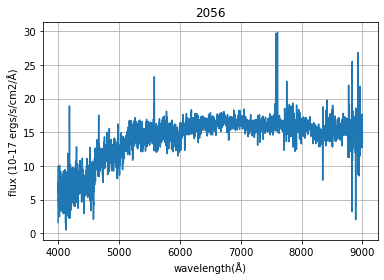

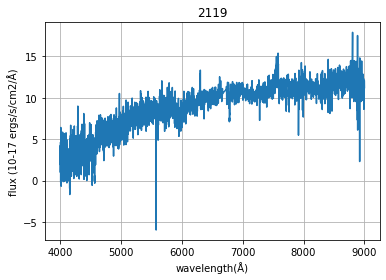

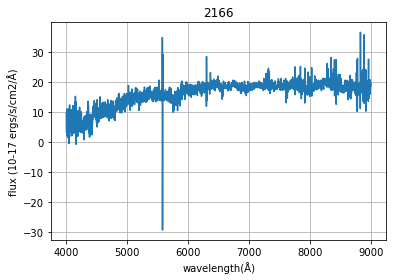

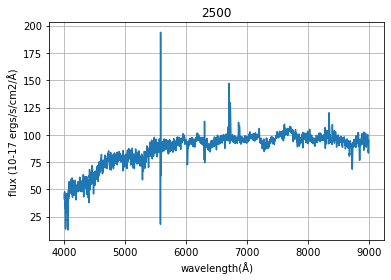

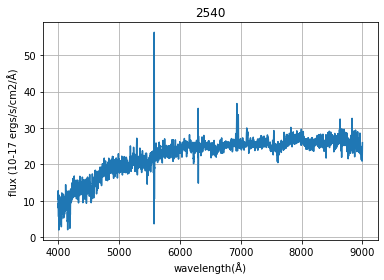

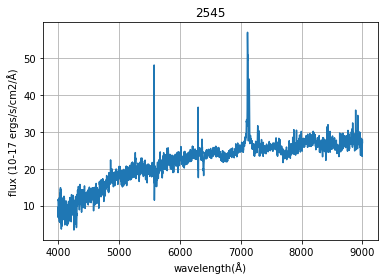

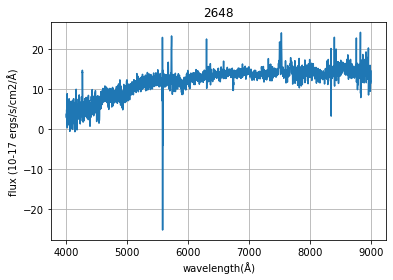

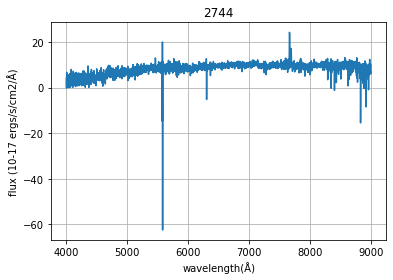

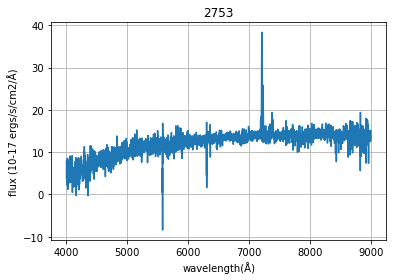

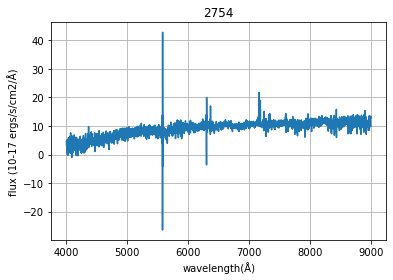

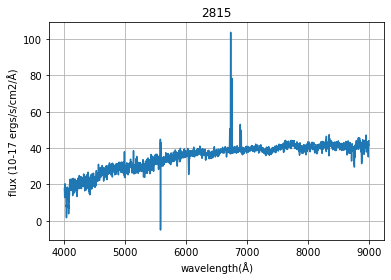

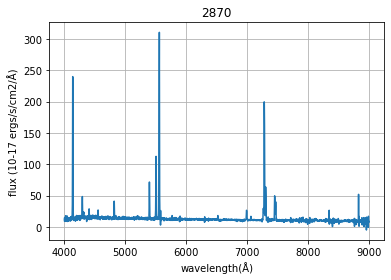

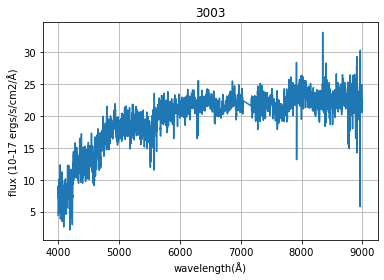

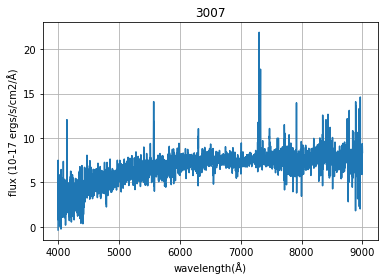

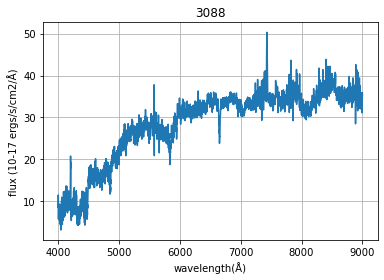

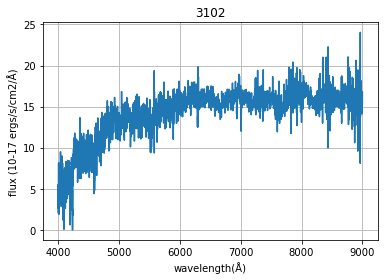

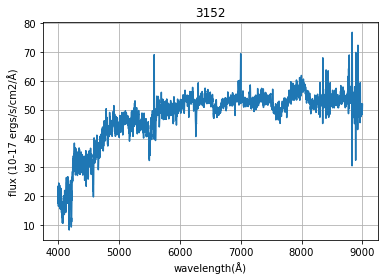

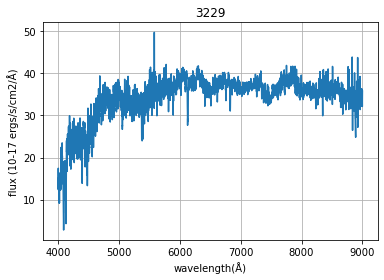

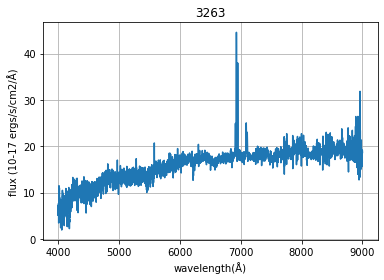

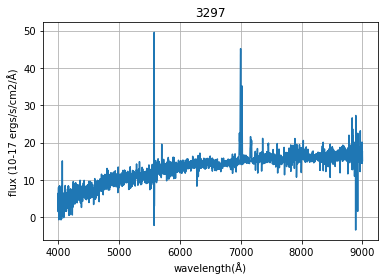

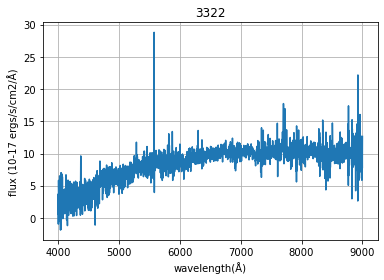

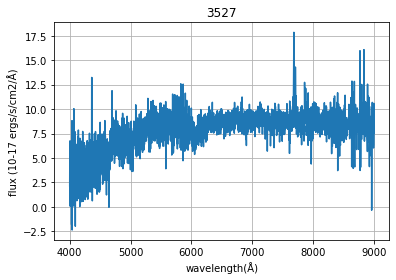

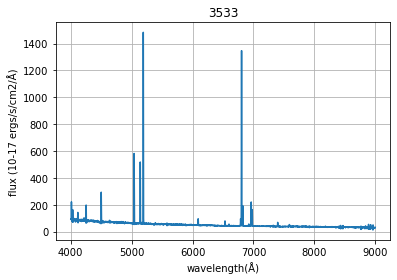

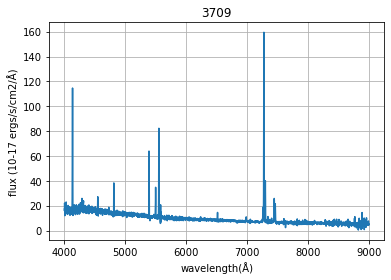

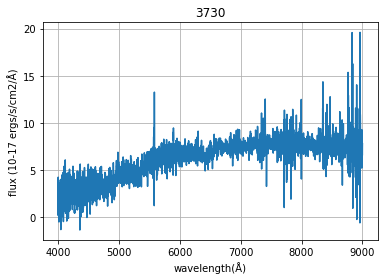

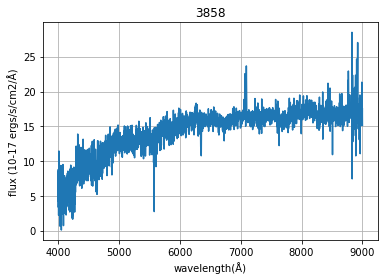

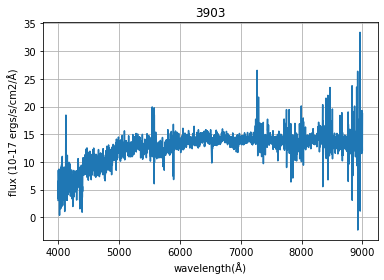

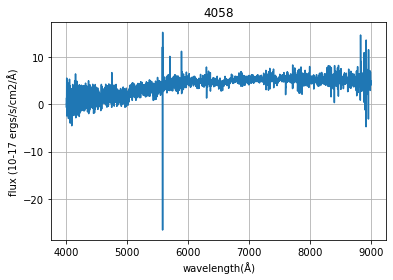

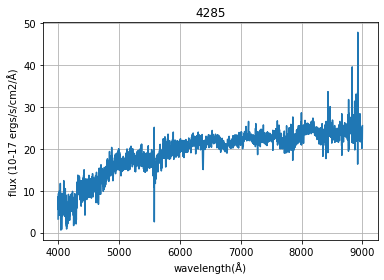

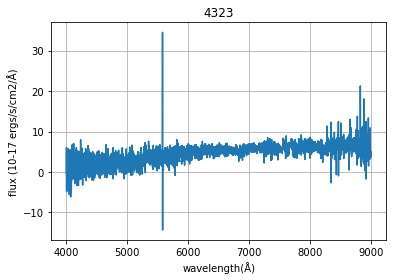

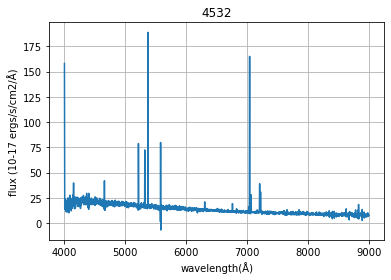

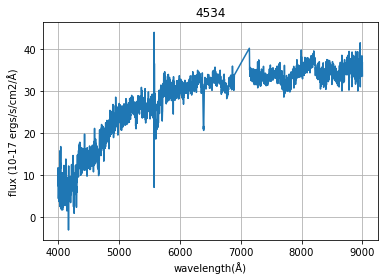

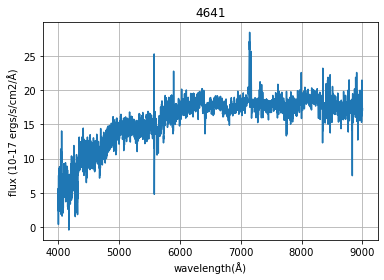

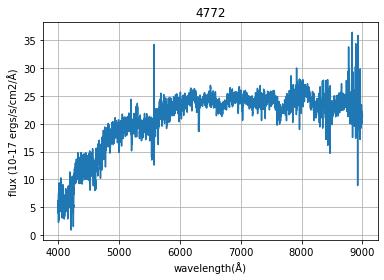

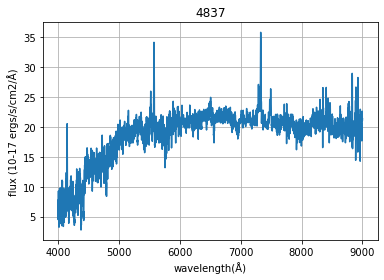

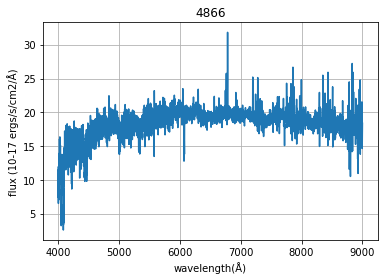

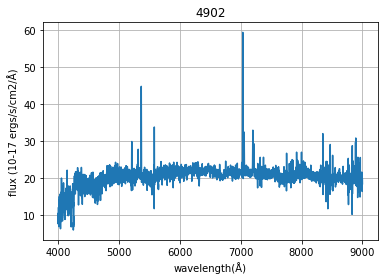

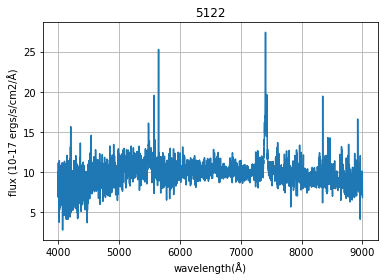

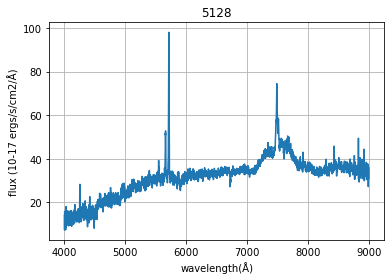

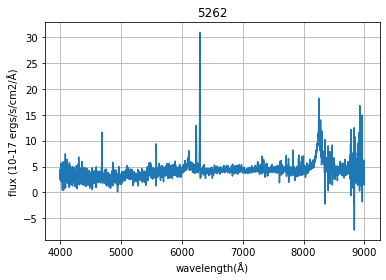

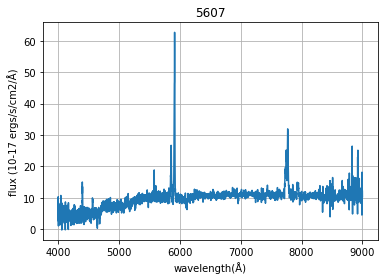

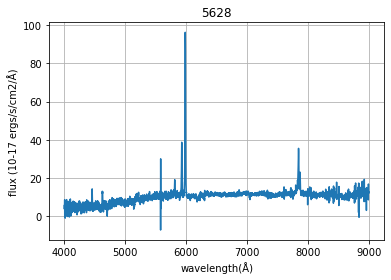

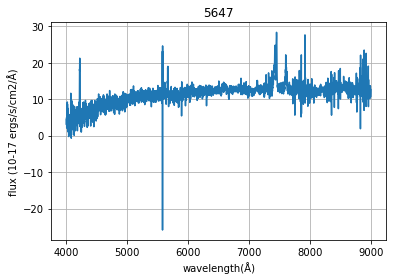

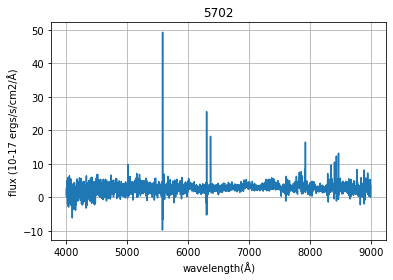

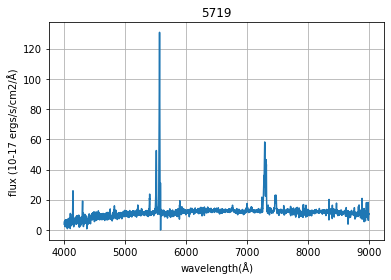

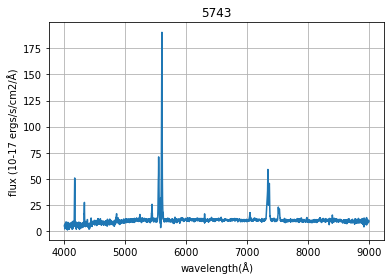

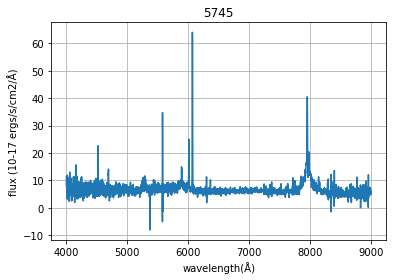

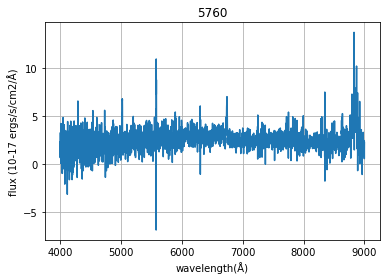

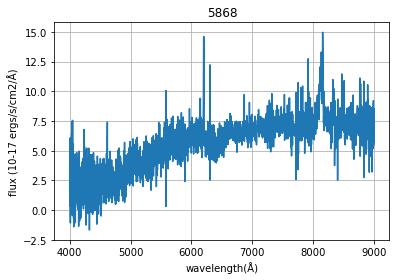

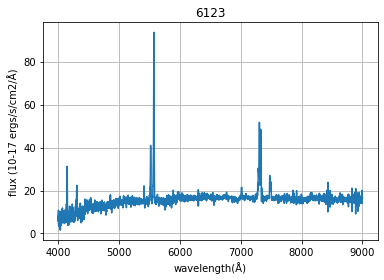

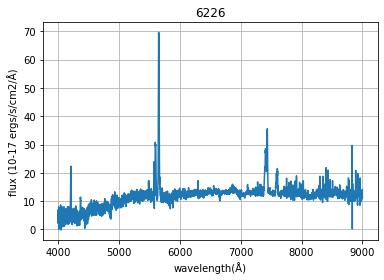

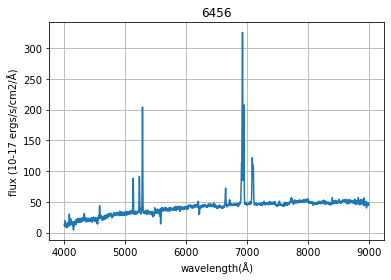

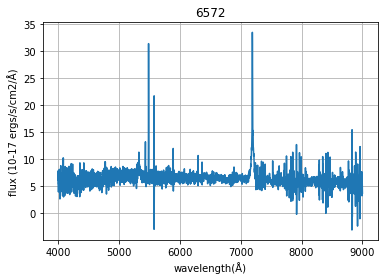

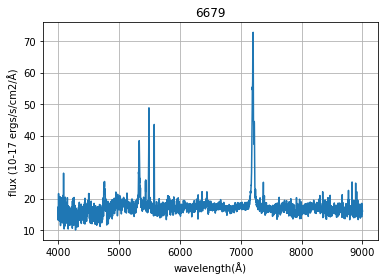

In [23]:
for i in wrong_predictions:  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## Simple benchmarking with the scikit-learn package

In [24]:
# SVM support vector machine
# see: https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(data_training, labels_training)
clf.score(data_test, labels_test)

0.3985714285714286

In [26]:
# Random forest
# see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=123)
clf2.fit(data_training, labels_training)
clf2.score(data_test, labels_test)

0.7628571428571429

In [29]:
# Logistic regression
# see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=10000, random_state=123)
clf1.fit(data_training, labels_training)
clf1.score(data_test, labels_test)

0.8514285714285714

In [27]:
# Gaussian naive Bayes
# see: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.naive_bayes import GaussianNB
clf3 = GaussianNB()
clf3.fit(data_training, labels_training)
clf3.score(data_test, labels_test)

0.48714285714285716